In [1]:
%pylab inline


from __future__ import division
from scipy.integrate import quad
from copy import copy, deepcopy
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

class demandFunc():
    
    def __init__(self,**params):
        for key in params:
                setattr(self, key, params[key])

    def demand(self, P):
        
        return (self.multiplier*P**self.elasticity)
        
    def invDemand(self, Q):
        
                return (self.multiplier/Q)**(1/self.elasticity)

    def demandCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.demand, Pvec)
    
    def invDemandCurve(self, Qvec):
        '''
        Qcev is a vector of quantities
        '''
        return map(self.invDemand, Qvec)
        
        
class supplyFunc():

    def __init__(self,interval_points):
        '''
        interval points is a set of tupples (Q,P)
        '''
        self.interval_points = copy(interval_points)
        self.interval_points.sort(reverse=True)
        
    def supply(self,P):

        highest_q = self.interval_points[0][0]
        for q,p in self.interval_points:
            if p > P:
                highest_q = q
                continue
            if p <= P:
                return highest_q
        return highest_q
            
    def invSupply(self, Q):
               
        highest_p = self.interval_points[0][1]
        for q,p in self.interval_points:
            if q < Q:
                return p
            if q >= Q:
                highest_p = p
                continue
        return highest_p

    def supplyCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.supply, Pvec)
    
    def invSupplyCurve(self, Qvec):
        '''
        Qvec is a vector of quantities
        '''
        return map(self.invSupply, Qvec)
    
class market(object):
    
    def __init__(self, demandFunc, supplyFunc):
        self.demandFunc, self.supplyFunc = demandFunc, supplyFunc
        '''
        if ad < az:
            raise ValueError('Insufficient demand.')
        '''
        self.findEQ()
        self.find_cSurplus()
    
    def findEQ(self):
        "Return equilibrium price"
        self.ranges = ((1,(self.supplyFunc.interval_points[0][1])*1.2))
        optimalFunc = lambda q : np.abs(self.demandFunc.invDemand(q) - self.supplyFunc.invSupply(q))
        results = optimize.brute(optimalFunc, (self.ranges, ), full_output=True,
                              finish=optimize.fmin)
        self.equilibriumQ = results[0][0]
        self.equilibriumP = self.demandFunc.invDemand(self.equilibriumQ)
    
    def find_cSurplus(self):
        "Compute consumer surplus"
        intDemand, errorD = quad(self.demandFunc.invDemand, 1, self.equilibriumQ)
        intSupply, errorS = quad(self.supplyFunc.invSupply, 1, self.equilibriumQ)
        intDemand += self.demandFunc.invDemand(1) #TODO: make sure this is correct
        self.consumerSurplus = intDemand - intSupply

Populating the interactive namespace from numpy and matplotlib


/home/alex/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [16]:
class scenarioSimulator(object):
    
    def __init__(self, market):
        self.market              = market
        self.grid                = np.linspace(1,(self.market.supplyFunc.interval_points[0][1]*1.2),300)
        self.surplusParams       = {
                                    'facecolor':'green',
                                    'alpha':.3,
                                    'label':'surplus'
                                    }
        self.surplusAddParams = {
                                    'color':'blue',
                                    'alpha':.3,
                                    'label':'new surplus'
                                    }
        self.surplusLossParams = {
                                    'color':'red',
                                    'alpha':.2,
                                    'label':'lost surplus'
                                    }        
        self.titlefont           = {
                                    'family' : 'serif',
                                    'color'  : 'black',
                                    'weight' : 'bold',
                                    'size'   : 16,
                                    }
        self.labelfont           = {
                                    'family' : 'sans-serif',  # (cursive, fantasy, monospace, serif)
                                    'color'  : 'black',       # html hex or colour name
                                    'weight' : 'normal',      # (normal, bold, bolder, lighter)
                                    'size'   : 14,            # default value:12
                                    }
    
    def plotDemand(self,ax):
        return ax.plot(self.grid, self.market.demandFunc.invDemandCurve(self.grid), lw=2, alpha=0.6, label='demand')
        
    def plotSupply(self,ax):
        return ax.plot(self.grid, self.market.supplyFunc.invSupplyCurve(self.grid), lw=2, alpha=0.6, label='supply')
    
    def plotPrice(self):
        for ax in self.fig.axes
            ax.plot(np.linspace(0,self))
    
    def plotQuantity(self):
        pass
    
    def plotDemandShift(self,ax,demandShift=None,populationShift=None):
        self.demandShiftMarket = deepcopy(self.market)
        self.demandShiftMarket.demandFunc.multiplier += demandShift
        self.demandShiftMarket.findEQ()
        self.demandShiftPlot = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid)
        return ax.plot(self.grid, self.demandShiftPlot, lw=2, alpha=0.6, label='new demand')
    
    def plotSupplyShift(self,ax,supplyShift=None):
        self.supplyShiftMarket = deepcopy(self.market)
        self.supplyShiftMarket.supplyFunc.interval_points = [(i,j+supplyShift) for i,j in self.market.supplyFunc.interval_points] 
        self.supplyShiftMarket.findEQ()
        self.supplyShiftPlot = self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid)
        return ax.plot(self.grid, self.supplyShiftPlot, lw=2, alpha=0.6, label='new supply')
    
    def plotSurplus(self,ax,price=None):
        try:
            return ax.fill_between(
                                   self.grid,
                                   self.market.demandFunc.invDemandCurve(self.grid), 
                                   self.market.supplyFunc.invSupplyCurve(self.grid), 
                                   where = self.market.demandFunc.invDemandCurve(self.grid) > np.maximum(price,self.market.equilibriumP), 
                                   **self.surplusParams
                                   )
        except AttributeError:
            pass
        
    def plotSupplyChangeSurplus(self,ax,supplyShift=None):
        try:
            if supplyShift >= 0:
                return ax.fill_between(
                                       self.grid,
                                       self.market.supplyFunc.invSupplyCurve(self.grid), 
                                       np.minimum(self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid),self.market.demandFunc.invDemandCurve(self.grid)),
                                       where = self.market.demandFunc.invDemandCurve(self.grid) > self.supplyShiftMarket.equilibriumP, 
                                       **self.surplusLossParams
                                       )      
            else:  
                return ax.fill_between(
                                       self.grid,
                                       self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid), 
                                       np.minimum(self.market.supplyFunc.invSupplyCurve(self.grid), self.market.demandFunc.invDemandCurve(self.grid)), 
                                       where = self.market.demandFunc.invDemandCurve(self.grid) > self.supplyShiftMarket.equilibriumP, 
                                       **self.surplusAddParams
                                       )        
        except AttributeError:
            pass
        
    def plotDemandChangeSurplus(self,ax,demandShift=None):
        try:
            if demandShift >= 0:
                return ax.fill_between(
                                       self.grid,
                                       self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), 
                                       np.maximum(self.market.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)),
                                       where = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid) > self.demandShiftMarket.equilibriumP,
                                       **self.surplusAddParams
                                       )        
            else:
                return ax.fill_between(
                                       self.grid,
                                       self.market.demandFunc.invDemandCurve(self.grid), 
                                       np.maximum(self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)), 
                                       where = self.market.demandFunc.invDemandCurve(self.grid) > self.market.equilibriumP, 
                                       **self.surplusLossParams
                                       )        
        except AttributeError:
            pass

    def drawPrice(self,price):
        
        self.drawFigure(priceLevel=price,EQ=False)
    
    def drawQuantity(self,quantity):
        
        self.drawFigure(priceLevel=self.market.demandFunc.invDemand(quantity),EQ=False)
        
    def drawSupplyShift(self,shift=1):
        
        self.drawFigure(supplyShift=shift)
    
    def drawDemandShift(self,shift=1):
        
        self.drawFigure(demandShift=shift)
        
    def drawShifts(self, demandShift=1, supplyShift=1):

        self.drawFigure(demandShift=demandShift, supplyShift=supplyShift)

    def drawCapitalExpTradeoff(self,budget,split):
        
        supplyShift1 = -1*budget*split
        supplyShift2 = -1*budget*(1-split)
        
        self.drawFigure(supplyShift1=supplyShift1,supplyShift2=supplyShift2,numPlots=2,otherMarket=None,
                      priceLevel=None,price2=None)

    def drawPopulationShift(self,size,away=False):
        
        if away:
            size=-size
        demandShift1 = size
        demandShift2 = -size
        
        self.drawFigure(demandShift1=demandShift1,demandShift2=demandShift2,numPlots=2,otherMarket=None,
                      priceLevel=None,price2=None)
    
        
    def drawOptimalTradeoff(self,totalSupply,otherMarket = None):
        #need to add back integrals for Q < 1
        if self.market.equilibriumQ + otherMarket.equilibriumQ <= totalSupply:
            raise ValueError('totalSupply is too large, there is no constraint')
        surplusEquation1 = lambda q: self.market.demandFunc.invDemand(q) - self.market.supplyFunc.invSupply(q)
        surplusEquation2 = lambda q: otherMarket.demandFunc.invDemand(q) - otherMarket.supplyFunc.invSupply(q)
        
        intDemand1 = lambda q: quad(surplusEquation1, 1, q)[0] 
        intDemand2 = lambda q: quad(surplusEquation2, 1, q)[0] 
        
        optimalFunction = lambda q_pct : -1*(intDemand1(q_pct*totalSupply) + intDemand2((1-q_pct)*totalSupply))
        result = optimize.brute(optimalFunction,((.001,.999), ),full_output=True,finish=optimize.fmin)
        self.drawTradeoff(totalSupply,result[0],otherMarket = otherMarket)
        
    def drawTradeoff(self,totalSupply,firstMarketFrac,otherMarket = None):
        
        if firstMarketFrac < 0 or firstMarketFrac > 1:
            raise ValueError('Input must be numeric between 0 and 1 inclusive.')
        quant1 = totalSupply * firstMarketFrac
        quant2 = totalSupply - quant1
        price1 = self.market.demandFunc.invDemand(quant1)
        if otherMarket is not None:
            price2 = otherMarket.demandFunc.invDemand(quant2)
        else:
            price2 = self.market.demandFunc.invDemand(quant2)
        self.drawFigure(priceLevel=price1,price2=price2,otherMarket=otherMarket,numPlots=2,EQ=False)
            
    def drawFigure(self, numPlots=1, EQ = True, **kwargs):
        fig, ax_array = plt.subplots(1, numPlots,figsize = (5*numPlots,5),sharey=True)
        for i,ax in enumerate(np.ravel(ax_array)):
            
            ax.set_xlim([1,self.market.supplyFunc.interval_points[0][1]])
            ax.set_ylim([1,self.market.supplyFunc.interval_points[0][0]*2.5])
            try:
                kwargs['demandShift'] = kwargs['demandShift'+str(i+1)]
            except KeyError:
                pass
            try:
                kwargs['supplyShift'] = kwargs['supplyShift'+str(i+1)]
            except KeyError:
                pass
            if i == 0:
                for i in kwargs['points']points:
                exec('self.plot1.%s = %s' % ('self.plot' + str(i), points[i]))
                exec('self.plot1.%s = %s' % ('self.plot' + str(i), points[i]))

                points = [priceLevel,copy(self.)]
                self.drawAxes(ax,EQ=EQ,**kwargs)
                continue
            if kwargs['otherMarket'] is not None:
                self.tempMarket = deepcopy(self.market)
                self.market = deepcopy(kwargs['otherMarket'])
            del kwargs['priceLevel']
            
            self.drawAxes(ax,EQ=EQ,priceLevel=kwargs['price2'], **kwargs)
            if kwargs['otherMarket'] is not None:
                self.market = deepcopy(self.tempMarket)
        self.fig=fig
        
    def drawAxes(self,ax,showSurplus=True, supplyShift = None, demandShift = None, **kwargs):
        
        #unpack key word arguments
        for i in kwargs:
            try:
                exec('%s = %s' % (i, repr(kwargs[i])))
            except SyntaxError:
                continue
        
        #set up titles / markings for graph
        title = 'Supply and Demand for Water'

        
        self.plotDemand(ax)
        self.plotSupply(ax)
        if supplyShift:
            self.plotSupplyShift(ax,supplyShift=supplyShift)
        if demandShift:
            self.plotDemandShift(ax,demandShift=demandShift)
        if showSurplus:
            if not EQ:
                self.plotSurplus(ax,price=array(priceLevel))
                title = 'Quantity Constraints on Water Market'
                self.titlefont['size']=12
            else:
                self.plotSurplus(ax, price = self.market.equilibriumP)
                self.plotDemandChangeSurplus(ax, demandShift=demandShift)
                self.plotSupplyChangeSurplus(ax, supplyShift=supplyShift)
        
        ax.set_title(title, fontdict=self.titlefont) 
        ax.set_xlabel('Quantity of Water (Mcm/capita)', fontdict=self.labelfont)
        ax.set_ylabel('Price ($/mcm)', fontdict=self.labelfont)
        ax.legend(loc='best', frameon=False, fontsize=12, markerscale=.6,ncol=2,columnspacing=.8)
        
        self.supplyShiftMarket, self.demandShiftMarket= None, None
        


In [17]:
supplyLevels = [(0,2),(3,4),(6,7)]
highlandsSupplyLevels = [(i,j+3) for i,j in supplyLevels]
demand_parameters = {'multiplier':20,'elasticity':1.5}
Market = market(demandFunc(**demand_parameters), supplyFunc(supplyLevels))
lowAltMarket = market(demandFunc(**demand_parameters), supplyFunc(highlandsSupplyLevels))
graphMaker = scenarioSimulator(Market)

Axes(0.125,0.125;0.775x0.775)


'\ngraphMaker.drawPopulationShift(2,away=True)\n\ngraphMaker.drawFigure()\ngraphMaker.drawPrice(5)\ngraphMaker.drawPrice(10.07)\ngraphMaker.drawQuantity(2.5)\ngraphMaker.drawTradeoff(4,.4)\n\ngraphMaker.drawOptimalTradeoff(4, otherMarket=lowAltMarket)\n\ngraphMaker.drawDemandShift(4)\ngraphMaker.drawDemandShift(-2)\n\ngraphMaker.drawSupplyShift()\ngraphMaker.drawSupplyShift(-2)\n'

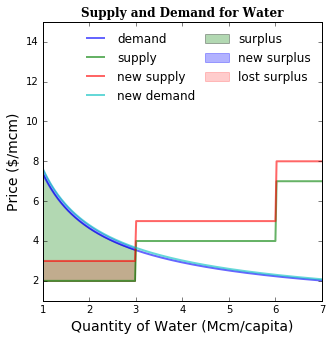

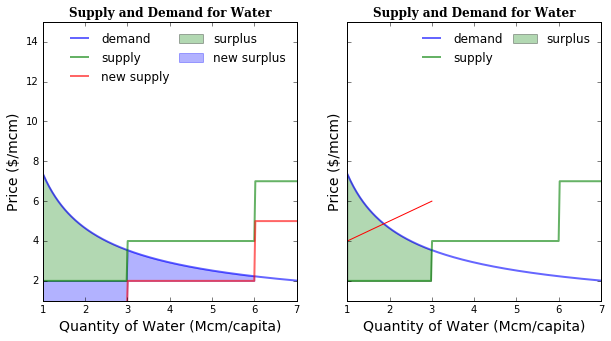

In [33]:
graphMaker.drawShifts()
print(graphMaker.fig.axes[0])
#graphMaker.drawFigure(demandShift=2,otherMarket=None,priceLevel=None,price2=None,numPlots=2)

'''
graphMaker.drawPopulationShift(2,away=True)

graphMaker.drawFigure()
graphMaker.drawPrice(5)
graphMaker.drawPrice(10.07)
graphMaker.drawQuantity(2.5)
graphMaker.drawTradeoff(4,.4)

graphMaker.drawOptimalTradeoff(4, otherMarket=lowAltMarket)

graphMaker.drawDemandShift(4)
graphMaker.drawDemandShift(-2)

graphMaker.drawSupplyShift()
graphMaker.drawSupplyShift(-2)
'''

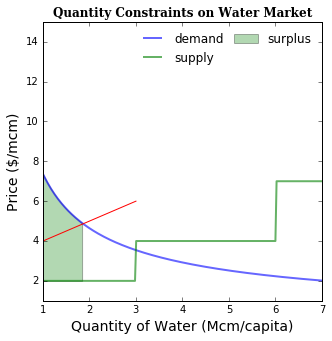

In [24]:
interact(graphMaker.drawPrice,price=(1,10,.1))

<function ipywidgets.widgets.interaction.<lambda>>

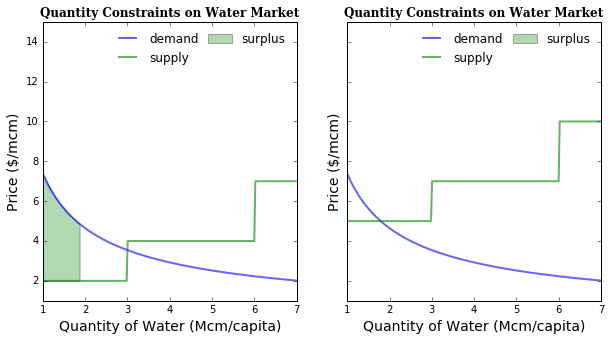

In [6]:
interact(graphMaker.drawOptimalTradeoff,totalSupply=(1,6,.2), otherMarket=fixed(lowAltMarket))

<function ipywidgets.widgets.interaction.<lambda>>

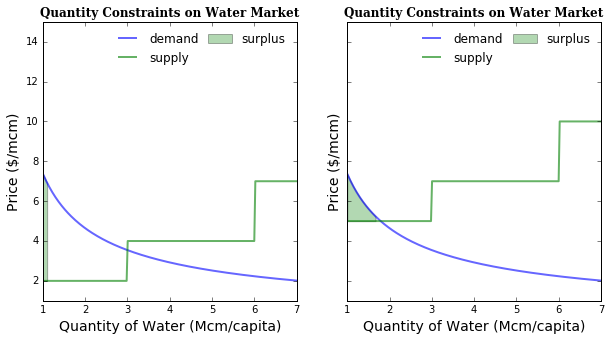

In [7]:
interact(graphMaker.drawTradeoff,totalSupply=(1,6,.2), firstMarketFrac=(.001,.999,.1),otherMarket=fixed(lowAltMarket))

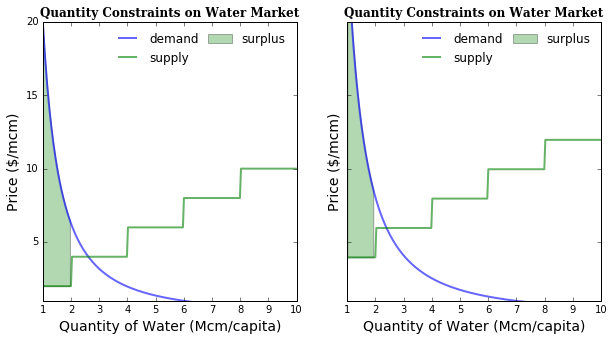

In [8]:
kwargDict = {
             'optimize':'True', 
             'waterSupply':4,
             'waterSharePct':.4,
             'supplyChange':2,
             'demandChange':1
            }


def buildSupplyPoints(width, height, steps):
    supplyPoints = [(0,height)] 
    supplyPoints.extend([(supplyPoints[0][0]+width*(i+1),supplyPoints[0][1]+height*(i+1)) for i in range(int(steps/width))])
    return supplyPoints

def makeKwargs(kwargDict):
    mixMaxRangeTupples = {}
    for k,v in kwargDict.iteritems():
        try:
            mixMaxRangeTupples[k]=(v-2*v,v+2*v,v/50)
        except TypeError:
            continue
    return mixMaxRangeTupples

@interact(**makeKwargs(kwargDict))
def compareMarketsSimple(optimize=('True','False'),waterSharePct=None,waterSupply=None,supplyChange=None,demandChange=None):
    supplyLevels = buildSupplyPoints(2,2,8)
    newSupplyLevels = [(i,j+supplyChange) for i,j in supplyLevels]
    demand_parameters = {'multiplier':6,'elasticity':.6}
    newDemand_parameters = {'multiplier':6+demandChange,'elasticity':.6}
    Market = market(demandFunc(**demand_parameters), supplyFunc(supplyLevels))
    newMarket = market(demandFunc(**newDemand_parameters), supplyFunc(newSupplyLevels))
    graphMaker = scenarioSimulator(Market)
    if optimize == 'True':
        graphMaker.drawOptimalTradeoff(totalSupply = waterSupply, otherMarket=newMarket)
    else:
        graphMaker.drawTradeoff(waterSupply,waterSharePct, otherMarket=newMarket)

        
kwargDict1 = {
             'optimize':'True',
             'waterSupply':40, 
             'waterSharePct':.4, 
             'demandMult1':60,
             'demandMult2':60,
             'demandElas1':.6,
             'demandElas2':.6,
             'stepWidth1':2,
             'stepHeight':2,
             'steps':8,
             'supplyChange':2,
             'demandChangeM':1,
             'demandChangeE':.1,
            }